In [1]:
import torch
#from torch.utils.data import DataLoader
#from deep_learning import ResNetDataset


from deep_learning import custom_dataloader
from deep_learning import NoNoiseDataset

from deep_learning import ResNet50

import torch.nn as nn
import torch.optim as optim
from shared_utils import _grid_lens

# Choose the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


model = ResNet50(num_classes=2)
model = model.float()  # Converts all weights and buffers to torch.float64
model = model.to(device)

# --- Setup and Training ---
grid_lens = _grid_lens(6.0, 100, device=device)



# # Create an instance of your training dataset.
# train_dataset=ResNetDataset(catalog_name="reposition_sources", use_only_a_percent=50, mode="on_gpu_generation", uncropped_grid=grid_lens)

# train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=0)

# Create dataset
train_dataset= NoNoiseDataset(catalog_name="SIS_10e10_sub_train", samples_used=2000, grid_width_arcsec=6.0, grid_pixel_side= 100, broadcasting=True)

# Create dataloader
train_loader = custom_dataloader(train_dataset, batch_size=100, num_workers=0)


# Debug: Check what one batch looks like
test_images, test_labels = next(iter(train_loader))
print("\n[DEBUG] Original test_images shape:", test_images.shape)
print("[DEBUG] Original test_labels shape:", test_labels.shape)

# If the images don't have a channel dimension, add one.
if test_images.ndim == 3:
    test_images = test_images.unsqueeze(1)
    print("[DEBUG] After unsqueeze, test_images shape:", test_images.shape)
else:
    print("[DEBUG] Test images already have a channel dimension.")


print("\n[DEBUG] Model architecture:")
print(model)
print("\n[DEBUG] First conv layer weight shape:", model.conv1.weight.shape)

# Test a single forward pass before training
try:
    print("\n[DEBUG] Attempting a single forward pass on the test batch...")
    test_images = test_images.to(device)
    test_labels = test_labels.to(device).long()
    test_outputs = model(test_images)
    print("[DEBUG] Single forward pass outputs shape:", test_outputs.shape)
except Exception as e:
    print("[DEBUG] Error during single forward pass:", e)
    exit()

# Set up loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10
print("\n[DEBUG] Starting training...\n")
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        # Ensure images have a channel dimension: [batch_size, 1, H, W]
        if images.ndim == 3:
            images = images.unsqueeze(1)
        if batch_idx == 0:
            print(f"[DEBUG] Epoch {epoch+1} first batch images shape: {images.shape}, labels shape: {labels.shape}")
        
        images = images.to(device)
        labels = labels.to(device).long()
        
        optimizer.zero_grad()       # Zero the gradients
        outputs = model(images)     # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()             # Backward pass
        optimizer.step()            # Update parameters
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    print(f"[DEBUG] Epoch {epoch+1} Loss: {epoch_loss:.4f}")

# --- Saving the Model Parameters ---

# Save the trained model's parameters to a file.
model_save_path = 'resnet50_trained_parameters.pth'
torch.save(model.state_dict(), model_save_path)
print(f"\n[DEBUG] Model parameters saved to {model_save_path}")





Using device: cuda
Using device: cuda
Currently this dataloader is calculating the images in float32
Currently not cropping and rotating, set final_transform in the intialization to True to use it

[DEBUG] Original test_images shape: torch.Size([100, 1, 100, 100])
[DEBUG] Original test_labels shape: torch.Size([100])
[DEBUG] Test images already have a channel dimension.

[DEBUG] Model architecture:
ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), 

KeyboardInterrupt: 

In [6]:
import torch

from deep_learning import custom_dataloader
from deep_learning import NoNoiseDataset

from deep_learning import ResNet50


import torch.nn as nn
import torch.optim as optim
from shared_utils import _grid_lens

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

grid_lens = _grid_lens(6.0, 100, device=device)



test_dataset= NoNoiseDataset(catalog_name="SIS_10e10_sub_val_extended", samples_used=2000, grid_width_arcsec=6.0, grid_pixel_side= 100, broadcasting=False)

# Create dataloader
test_loader = custom_dataloader(test_dataset, batch_size=100, num_workers=0)





model = ResNet50(num_classes=2)
#load the saved parameters
model.load_state_dict(torch.load('resnet50_trained_parameters.pth'))

model.to(device)
# Set the model to evaluation mode.
model.eval()
correct = 0
total = 0

# We don't need gradients for evaluation.
with torch.no_grad():
    for images, labels in test_loader:
        # Ensure images have the channel dimension.
        if images.ndim == 3:
            images = images.unsqueeze(1)
        images = images.to(device)
        labels = labels.to(device).long()
        
        outputs = model(images)
        # Get the predicted class with the highest score
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"\n[DEBUG] Accuracy on the test dataset: {accuracy:.2f}%")

Using device: cuda
Currently this dataloader is calculating the images in float32

[DEBUG] Accuracy on the test dataset: 85.15%


In [12]:
import torch
from deep_learning import custom_dataloader
from deep_learning import NoNoiseDataset
from deep_learning import ResNet50
import torch.nn as nn
import torch.optim as optim
from shared_utils import _grid_lens

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



model = ResNet50(num_classes=2)
model = model.float()  # Converts all weights and buffers to torch.float64
model = model.to(device)

# --- Setup and Training ---
grid_lens = _grid_lens(6.0, 100, device=device)



# # Create an instance of your training dataset.
# train_dataset=ResNetDataset(catalog_name="reposition_sources", use_only_a_percent=50, mode="on_gpu_generation", uncropped_grid=grid_lens)

# train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=0)

# Create dataset
train_dataset= NoNoiseDataset(catalog_name="reposition_sources", samples_used=2000, uncropped_grid=grid_lens, broadcasting=True)

# Create dataloader
train_loader = custom_dataloader(train_dataset, batch_size=50, num_workers=0)

import time
time_start = time.time()
# Debug: Check what one batch looks like
for i in range(10):
    test_images, test_labels = next(iter(train_loader))

time_end = time.time()
print(f"\n[DEBUG] Time taken to load 10 batches: {time_end - time_start:.4f} seconds")


train_dataset= NoNoiseDataset(catalog_name="reposition_sources", samples_used=2000, uncropped_grid=grid_lens, broadcasting=False)

# Create dataloader
train_loader = custom_dataloader(train_dataset, batch_size=50, num_workers=0)

time_start = time.time()
# Debug: Check what one batch looks like
for i in range(10):
    test_images, test_labels = next(iter(train_loader))

time_end = time.time()
print(f"\n[DEBUG] Time taken to load 10 batches: {time_end - time_start:.4f} seconds")

Using device: cuda
Currently this dataloader is calculating the images in float32

[DEBUG] Time taken to load 10 batches: 1.4698 seconds
Using device: cuda
Currently this dataloader is calculating the images in float32


/home/francesco/Desktop/master_thesis_code/src/deep_learning/NN_datasets/custom_datasets/no_noise_dataset.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_tensor = torch.tensor(num_sub > 0, device=self.device).long()
/home/francesco/Desktop/master_thesis_code/src/deep_learning/NN_datasets/custom_datasets/no_noise_dataset.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_tensor = torch.tensor(image_tensor, dtype=self.image_data_type)
/home/francesco/Desktop/master_thesis_code/src/deep_learning/NN_datasets/custom_datasets/no_noise_dataset.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().deta


[DEBUG] Time taken to load 10 batches: 3.0651 seconds


In [6]:
import torch

torch.cuda.empty_cache()

In [3]:
import torch
from deep_learning import custom_dataloader
from deep_learning import NoNoiseDataset
from deep_learning import ResNet50
import torch.nn as nn
import torch.optim as optim
from shared_utils import _grid_lens

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')




# --- Setup and Training ---
grid_lens = _grid_lens(6.0, 1000,device=device, dtype=torch.float32)


# # Create an instance of your training dataset.
# train_dataset=ResNetDataset(catalog_name="reposition_sources", use_only_a_percent=50, mode="on_gpu_generation", uncropped_grid=grid_lens)

# train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=0)

# Create dataset
train_dataset= NoNoiseDataset(catalog_name="first_bad_testing_catalog", samples_used=1000, uncropped_grid=grid_lens, broadcasting=True)

# Create dataloader
train_loader = custom_dataloader(train_dataset, batch_size=10, num_workers=0)

import time
time_start = time.time()
torch.cuda.reset_peak_memory_stats()
torch.cuda.reset_accumulated_memory_stats()  
torch.cuda.empty_cache() 


# Debug: Check what one batch looks like
for i in range(10):
    test_images, test_labels = next(iter(train_loader))

time_end = time.time()
print(f"\n[DEBUG] Time taken to load 10 batches: {time_end - time_start:.4f} seconds")
print(torch.cuda.memory_summary())
torch.cuda.reset_peak_memory_stats()
torch.cuda.reset_accumulated_memory_stats()  
torch.cuda.empty_cache() 

train_dataset= NoNoiseDataset(catalog_name="first_bad_testing_catalog", samples_used=1000, uncropped_grid=grid_lens, broadcasting=False)

# Create dataloader
train_loader = custom_dataloader(train_dataset, batch_size=10, num_workers=0)

time_start = time.time()
# Debug: Check what one batch looks like
for i in range(10):
    test_images, test_labels = next(iter(train_loader))

time_end = time.time()
print(f"\n[DEBUG] Time taken to load 10 batches: {time_end - time_start:.4f} seconds")
print(torch.cuda.memory_summary())
torch.cuda.reset_peak_memory_stats()
torch.cuda.reset_accumulated_memory_stats()  
torch.cuda.empty_cache() 

Using device: cuda
Currently this dataloader is calculating the images in float32

[DEBUG] Time taken to load 10 batches: 3.4370 seconds
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 100516 KiB |   1964 MiB |  86535 MiB |  86497 MiB |
|       from large pool |  85937 KiB |   1950 MiB |  86533 MiB |  86495 MiB |
|       from small pool |  14578 KiB |     14 MiB |      1 MiB |      1 MiB |
|---------------------------------------------------------------------------|
| Act

/home/francesco/Desktop/master_thesis_code/src/deep_learning/NN_datasets/custom_datasets/no_noise_dataset.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_tensor = torch.tensor(num_sub > 0, device=self.device).long()
/home/francesco/Desktop/master_thesis_code/src/deep_learning/NN_datasets/custom_datasets/no_noise_dataset.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_tensor = torch.tensor(image_tensor, dtype=self.image_data_type)
/home/francesco/Desktop/master_thesis_code/src/deep_learning/NN_datasets/custom_datasets/no_noise_dataset.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().deta


[DEBUG] Time taken to load 10 batches: 3.6966 seconds
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 100516 KiB | 218708 KiB |  81765 MiB |  81765 MiB |
|       from large pool |  85937 KiB | 204115 KiB |  81308 MiB |  81308 MiB |
|       from small pool |  14578 KiB |  29156 KiB |    456 MiB |    456 MiB |
|---------------------------------------------------------------------------|
| Active memory         | 100516 KiB | 218708 KiB |  81765 MiB |  81765 MiB |
|       f

In [1]:
import torch
from deep_learning import custom_dataloader
from deep_learning import NoNoiseDataset
import torch.nn as nn
from shared_utils import _grid_lens
from matplotlib import pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# --- Setup and Training ---
grid_lens = _grid_lens(6.0, 1000,device=device)


train_dataset= NoNoiseDataset(catalog_name="first_bad_testing_catalog", samples_used=1000, uncropped_grid=grid_lens, broadcasting=True)

# Create dataloader
train_loader = custom_dataloader(train_dataset, batch_size=1, num_workers=0)

import time
time_start = time.time()
torch.cuda.reset_peak_memory_stats()
torch.cuda.reset_accumulated_memory_stats()  
torch.cuda.empty_cache() 


def func():
    for i in range(1):
        test_images, test_labels = next(iter(train_loader))
    
    return test_images
%prun images= func()

time_end = time.time()
print(f"\n[DEBUG] Time taken to load 10 batches: {time_end - time_start:.4f} seconds")
print(torch.cuda.memory_summary())
torch.cuda.reset_peak_memory_stats()
torch.cuda.reset_accumulated_memory_stats()  
torch.cuda.empty_cache() 


plt.imshow(images[0].cpu().numpy(), cmap='gray')
plt.show()


ImportError: cannot import name 'NoNoiseDataset' from 'deep_learning' (/home/francesco/Desktop/master_thesis_code/src/deep_learning/__init__.py)

 
[DEBUG] Time taken to load 10 batches: 2.7286 seconds
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 162116 KiB |   2965 MiB |  45188 MiB |  45188 MiB |
|       from large pool | 125000 KiB |   2929 MiB |  45185 MiB |  45185 MiB |
|       from small pool |  37116 KiB |     36 MiB |      2 MiB |      2 MiB |
|---------------------------------------------------------------------------|
| Active memory         | 162116 KiB |   2965 MiB |  45188 MiB |  45188 MiB |
|       

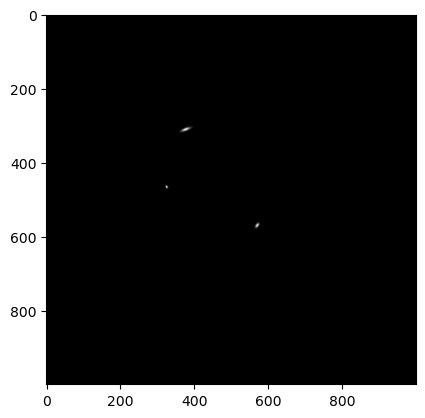

         121075 function calls (104715 primitive calls) in 2.722 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      770    1.060    0.001    1.060    0.001 {built-in method torch.tensor}
     4040    0.372    0.000    0.372    0.000 {built-in method torch.empty}
       10    0.167    0.017    0.718    0.072 lens_model.py:147(forward)
     6246    0.090    0.000    0.090    0.000 {built-in method torch.as_tensor}
       10    0.073    0.007    0.329    0.033 nfw.py:268(deflection_angle)
      300    0.070    0.000    0.508    0.002 gaussian_blob.py:150(forward)
       10    0.067    0.007    0.552    0.055 lens_model.py:118(deflection_field)
     1500    0.061    0.000    0.061    0.000 {method 'copy_' of 'torch._C.TensorBase' objects}
     1260    0.054    0.000    0.054    0.000 {built-in method torch.mul}
      300    0.045    0.000    0.151    0.001 gaussian_blob.py:10(__init__)
       20    0.045    0.002    0.045   

In [11]:
import time
time_start = time.time()
torch.cuda.reset_peak_memory_stats()
torch.cuda.reset_accumulated_memory_stats()  
torch.cuda.empty_cache() 


def func():
    for i in range(10):
        test_images, test_labels = next(iter(train_loader))
    
    return test_images
%prun images= func()

time_end = time.time()
print(f"\n[DEBUG] Time taken to load 10 batches: {time_end - time_start:.4f} seconds")
print(torch.cuda.memory_summary())
torch.cuda.reset_peak_memory_stats()
torch.cuda.reset_accumulated_memory_stats()  
torch.cuda.empty_cache() 


plt.imshow(images[0].cpu().numpy(), cmap='gray')
plt.show()


In [ ]:
import torch
from deep_learning import custom_dataloader
from deep_learning import NoNoiseDataset
from matplotlib import pyplot as plt
from shared_utils import _grid_lens
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# --- Setup and Training ---
grid_lens = _grid_lens(6.0, 1000,device=device)


# Create datasets with broadcasting=True and broadcasting=False
dataset_broadcasting_true = NoNoiseDataset(catalog_name="first_bad_testing_catalog", samples_used=1000, uncropped_grid=grid_lens, broadcasting=True)
dataset_broadcasting_false = NoNoiseDataset(catalog_name="first_bad_testing_catalog", samples_used=1000, uncropped_grid=grid_lens, broadcasting=False)

# Create dataloaders
loader_broadcasting_true = custom_dataloader(dataset_broadcasting_true, batch_size=30, num_workers=0, shuffle=False)
loader_broadcasting_false = custom_dataloader(dataset_broadcasting_false, batch_size=30, num_workers=0, shuffle=False)

# Get one batch from each loader
images_true, _ = next(iter(loader_broadcasting_true))
images_false, _ = next(iter(loader_broadcasting_false))

# Plot the first image from each batch for comparison
for i in range(30):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Broadcasting=True")
    plt.imshow(images_true[i].cpu().numpy().squeeze(), cmap='viridis')

    plt.subplot(1, 2, 2)
    plt.title("Broadcasting=False")
    plt.imshow(images_false[i].cpu().numpy().squeeze(), cmap='viridis')

    plt.show()


Using device: cuda
Currently this dataloader is calculating the images in float32
Using device: cuda
Currently this dataloader is calculating the images in float32


/home/francesco/Desktop/master_thesis_code/src/deep_learning/NN_datasets/custom_datasets/no_noise_dataset.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_tensor = torch.tensor(num_sub > 0, device=self.device).long()
